Imports

In [41]:
import cv2
import numpy as np
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from collections import Counter

Load Dataset

In [22]:
def load_data(train_folder, test_folder, image_size=(128, 64)):
    X_train = []  # Training data (character images)
    y_train = []  # Corresponding labels (characters)
    X_test = []   # Test data (segmented character images)
    y_test = []   # Corresponding labels for test (characters)

    # Loop through each folder in the training folder (representing character classes)
    for char_folder in os.listdir(train_folder):
        char_folder_path = os.path.join(train_folder, char_folder)

        # Skip if it's not a directory
        if not os.path.isdir(char_folder_path):
            continue
        
        # Extract label from the folder name (e.g., "digit_0" or "letter_A")
        label = char_folder.split('_')[-1]  # e.g., "0" or "A"

        # Loop through all images in the character folder
        for img_name in os.listdir(char_folder_path):
            if img_name.endswith('.png'):
                img_path = os.path.join(char_folder_path, img_name)
                char_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                # Resize the image to a fixed size (e.g., 32x32)
                char_image = cv2.resize(char_image, image_size)

                # Append to training data
                X_train.append(char_image)
                y_train.append(label)

    # Convert training data lists to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Loop through each folder in the segmented folder (representing license plates)
    for license_plate_folder in os.listdir(test_folder):
        license_plate_path = os.path.join(test_folder, license_plate_folder)

        # Skip if it's not a directory
        if not os.path.isdir(license_plate_path):
            continue

        # Loop through all segmented character images in the license plate folder
        for char_img_name in os.listdir(license_plate_path):
            if char_img_name.endswith('.png'):
                char_img_path = os.path.join(license_plate_path, char_img_name)
                char_image = cv2.imread(char_img_path, cv2.IMREAD_GRAYSCALE)

                # Resize the image to a fixed size (e.g., 32x32)
                char_image = cv2.resize(char_image, image_size)

                # Get the corresponding label from the license plate folder name
                label = license_plate_folder[0]  # For example, "Y" from "YWORRY"

                # Append to test data
                X_test.append(char_image)
                y_test.append(label)

    # Convert test data lists to numpy arrays
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Encode labels to integers
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)  # Fit and transform on training labels
    y_test = label_encoder.transform(y_test)  # Transform test labels based on the training labels

    return X_train, y_train, X_test, y_test, label_encoder


Plot Histogram

In [23]:
def plot_histograms(y_train, y_test, label_encoder):
    # Get the character labels from the label encoder
    class_labels = label_encoder.classes_

    # Plot histograms for the training and test labels
    plt.figure(figsize=(10, 5))

    # Plot histogram for training labels
    plt.subplot(1, 2, 1)
    plt.hist(y_train, bins=np.arange(len(class_labels) + 1) - 0.5, edgecolor='black')
    plt.title('Label Distribution in Training Data')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(len(class_labels)), class_labels)  # Set x-ticks to character labels

    # Plot histogram for test labels
    plt.subplot(1, 2, 2)
    plt.hist(y_test, bins=np.arange(len(class_labels) + 1) - 0.5, edgecolor='black')
    plt.title('Label Distribution in Test Data')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(len(class_labels)), class_labels)  # Set x-ticks to character labels

    plt.tight_layout()
    plt.show()


Histogram of Oriented Gradients (HOG)

In [24]:
class HOGDescriptor:
    def __init__(self, cell_size=(8, 8), block_size=(2, 2), nbins=9):
        self.cell_size = cell_size
        self.block_size = block_size
        self.nbins = nbins

    def compute_gradients(self, image):
        # Compute gradients along x and y directions
        gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        
        # Compute magnitude and angle
        magnitude = np.sqrt(gx**2 + gy**2)
        angle = np.arctan2(gy, gx) * (180 / np.pi) % 180  # Angle in degrees between 0 and 180
        
        return magnitude, angle

    def compute_histograms(self, magnitude, angle):
        # Divide the image into cells and compute histograms
        cell_histograms = []
        for i in range(0, magnitude.shape[0], self.cell_size[0]):
            for j in range(0, magnitude.shape[1], self.cell_size[1]):
                cell_magnitude = magnitude[i:i + self.cell_size[0], j:j + self.cell_size[1]]
                cell_angle = angle[i:i + self.cell_size[0], j:j + self.cell_size[1]]
                
                # Compute histogram for each cell
                hist = np.zeros(self.nbins)
                for m, a in zip(cell_magnitude.flatten(), cell_angle.flatten()):
                    bin_idx = int(a // (180 / self.nbins))  # Bin index
                    hist[bin_idx] += m  # Add magnitude to corresponding bin
                
                cell_histograms.append(hist)
        return np.array(cell_histograms)

    def compute(self, image):
        # Resize image
        image_resized = cv2.resize(image, (128, 64))
        #print(f"Resized Image Shape: {image_resized.shape}")
        
        # Compute gradients and histogram of gradients
        magnitude, angle = self.compute_gradients(image_resized)
        """ print(f"Gradient Magnitude Shape: {magnitude.shape}")
        print(f"Gradient Angle Shape: {angle.shape}") """
        
        # Compute histograms for cells
        cell_histograms = self.compute_histograms(magnitude, angle)
        #print(f"Number of Cells: {len(cell_histograms)}")
        
        # Group cells into blocks and normalize histograms
        block_histograms = []
        for i in range(0, len(cell_histograms) - (self.block_size[0] - 1) * 8, self.block_size[1]):
            block = cell_histograms[i:i + self.block_size[0] * self.block_size[1]]
            block_histograms.extend(block)
        
        # L2-norm normalization
        block_histograms = np.array(block_histograms)
        block_histograms /= np.sqrt(np.sum(block_histograms**2) + 1e-6)
        
        #print(f"Block Histograms Length: {len(block_histograms)}")
        return block_histograms

# Example usage:
image = cv2.imread('C:/Users/Cipleu/Documents/IULIA/SCOALA/facultate/Year 4 Semester 1/PRS/Lab/Project/charactersResulted/YWORRY/0.png', cv2.IMREAD_GRAYSCALE)  # Load grayscale image
hog = HOGDescriptor()
features = hog.compute(image)

# Print some of the computed features (optional)
print(f"Computed HOG Features: {features[:10]}")  # Print the first 10 HOG features


Computed HOG Features: [[0.         0.         0.         0.         0.0635649  0.00999658
  0.00140895 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.00017077 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.03713905 0.         0.         0.         0.01576884 0.07502698
  0.01430562 0.00770378 0.00795766]
 [0.02898134 0.         0.         0.         0.03070837 0.10165751
  0.0305129  0.01371728 0.03398846]
 [0.03713905 0.         0.         0.         0.01576884 0.07502698
  0.01430562 0.00770378 0.00795766]
 [0.02898134 0.         0.         0.         0.03070837 0.10165751
  0.0305129  

Naive Bayesian Classifier

In [35]:
from collections import defaultdict
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class NaiveBayesClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.class_probs = defaultdict(float)  # Class probabilities
        self.feature_probs = defaultdict(lambda: defaultdict(float))  # Feature probabilities given class

    def fit(self, X_train, y_train):
        """
        Train Naive Bayes classifier.
        
        :param X_train: List of feature vectors
        :param y_train: List of class labels
        """
        n_samples = len(X_train)
        class_counts = defaultdict(int)
        
        # Count occurrences of each class
        for label in y_train:
            class_counts[label] += 1
        
        # Calculate class probabilities
        for label, count in class_counts.items():
            self.class_probs[label] = count / n_samples
        
        # Calculate feature probabilities given each class
        feature_counts = defaultdict(lambda: defaultdict(int))
        for i in range(n_samples):
            label = y_train[i]
            features = X_train[i]
            
            # Convert the entire feature vector to a tuple
            features_tuple = tuple(features.flatten())  # Flatten the ndarray and convert to tuple
            
            for feature in features_tuple:
                feature_counts[label][feature] += 1

        for label, features in feature_counts.items():
            total_features = sum(features.values())
            for feature, count in features.items():
                self.feature_probs[label][feature] = count / total_features

        return self  # Return self to comply with scikit-learn's fit method

    def predict(self, X_test):
        """
        Predict class labels for the given test data.
        
        :param X_test: List of feature vectors to classify
        :return: List of predicted class labels
        """
        predictions = []
        for features in X_test:
            class_scores = {}
            for label, class_prob in self.class_probs.items():
                score = np.log(class_prob)
                for feature in features.flatten():  # Flatten features for prediction
                    feature_prob = self.feature_probs[label].get(feature, 1e-5)  # Apply Laplace smoothing
                    score += np.log(feature_prob)
                class_scores[label] = score
            predicted_class = max(class_scores, key=class_scores.get)
            predictions.append(predicted_class)
        return predictions


Voting Mechanism

In [39]:
class VotingClassifier:
    def __init__(self, classifiers, weights=None):
        # Extract classifier instances from the list of tuples
        self.classifiers = [clf[1] for clf in classifiers]  
        self.weights = weights if weights else [1] * len(self.classifiers)

    def fit(self, X_train, y_train):
        # Train each classifier
        for clf in self.classifiers:
            if hasattr(clf, 'train'):  # If classifier has 'train' method (custom classifier)
                clf.train(X_train, y_train)
            else:
                clf.fit(X_train, y_train)  # For sklearn classifiers, use 'fit'

    def predict(self, X_test):
        all_preds = []
        for clf in self.classifiers:
            all_preds.append(clf.predict(X_test))  # Collect predictions from all classifiers

        # Perform weighted voting
        weighted_preds = np.zeros(len(X_test))
        for i, preds in enumerate(zip(*all_preds)):  # Combine predictions for each sample
            class_votes = np.zeros(len(set(y_train)))  # Create a vote count array
            for j, pred in enumerate(preds):
                class_votes[int(pred)] += self.weights[j]  # Add weight to the prediction
            weighted_preds[i] = np.argmax(class_votes)  # Choose the class with the most votes
        return weighted_preds

Main - Only NB

In [ ]:
train_folder = 'C:/Users/Cipleu/Documents/IULIA/SCOALA/facultate/Year 4 Semester 1/PRS/Lab/Project/characters'  
test_folder = 'C:/Users/Cipleu/Documents/IULIA/SCOALA/facultate/Year 4 Semester 1/PRS/Lab/Project/charactersResulted'  

# Load data
X_train, y_train, X_test, y_test = load_data(train_folder, test_folder)

# Extract HOG features for training
hog = HOGDescriptor()
X_train_hog = [hog.compute(img) for img in X_train]
X_test_hog = [hog.compute(img) for img in X_test]

# Train Naive Bayes classifier
nb_classifier = NaiveBayesClassifier()
nb_classifier.train(X_train_hog, y_train)

# Make predictions on test data
predictions = nb_classifier.predict(X_test_hog)

# Evaluate accuracy
accuracy = np.mean(predictions == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [45]:
def new_load_data(folder_path):
    """
    Load images and their labels from a specified folder.
    The folder structure should have subfolders where each subfolder represents a class label.

    Parameters:
        folder_path (str): Path to the folder containing labeled subfolders with images.

    Returns:
        tuple: (X, y, label_encoder)
            - X: List of loaded image arrays
            - y: List of corresponding labels
            - label_encoder: Fitted LabelEncoder for decoding labels
    """
    X = []  # List to hold image data
    y = []  # List to hold labels
    label_encoder = LabelEncoder()

    # Iterate through each subfolder (class label)
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):  # Ensure it's a folder
            for filename in os.listdir(label_path):
                file_path = os.path.join(label_path, filename)
                try:
                    # Load the image in grayscale
                    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    if image is not None:
                        X.append(image)  # Append the image to X
                        y.append(label)  # Append the class label to y
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

    # Encode the labels into numeric values
    y_encoded = label_encoder.fit_transform(y)

    return X, y_encoded, label_encoder

Main - NB only on Characters Folder

In [47]:
train_folder = 'C:/Users/Cipleu/Documents/IULIA/SCOALA/facultate/Year 4 Semester 1/PRS/Lab/Project/characters'

# Load data using new_load_data
X, y, label_encoder = new_load_data(train_folder)

# Split data into 80% training and 20% testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract HOG features
hog = HOGDescriptor()
X_train_hog = [hog.compute(img) for img in X_train]
X_test_hog = [hog.compute(img) for img in X_test]

# Train Naive Bayes classifier
nb_classifier = NaiveBayesClassifier()
nb_classifier.fit(X_train_hog, y_train)

# Make predictions on test data
predictions = nb_classifier.predict(X_test_hog)

# Evaluate accuracy
accuracy = np.mean(predictions == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 2.77%


Main - Voting Mechanism

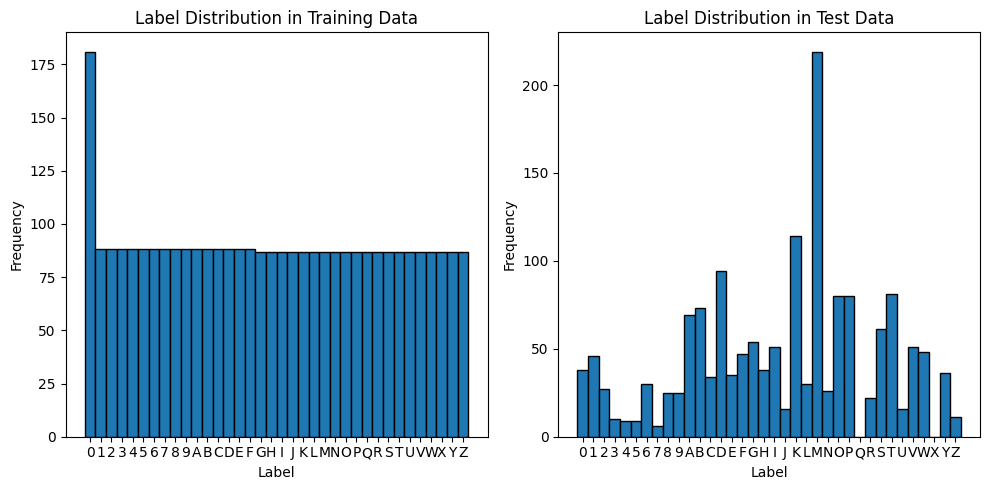

Extracting HOG features for training
Training Naive Bayes classifier
Training SVM classifier
Training Random Forest classifier
Training K-Nearest Neighbors classifier
Compute classifier accuracies using cross-validation
Classifier Accuracies: [np.float64(0.026843291673800153), np.float64(0.9645128307557688), np.float64(0.9638969735014934), np.float64(0.9419948068253152)]
Weights: [np.float64(0.009265100044860518), np.float64(0.3329065593034523), np.float64(0.3326939930078), np.float64(0.32513434764388727)]
Accuracy: 2.05%


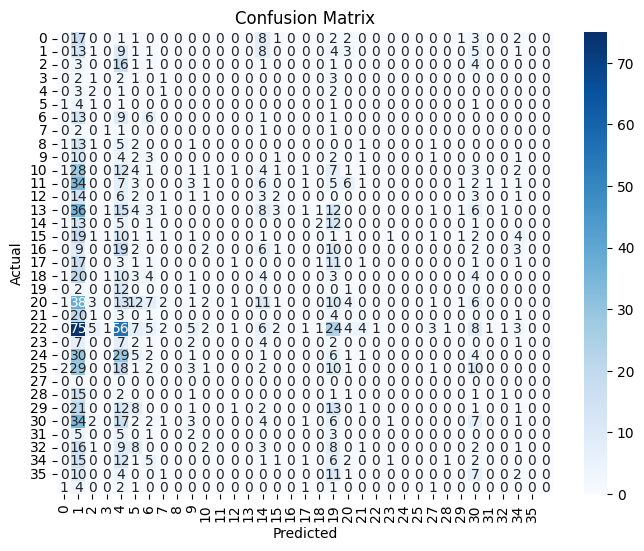


Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        38
         1.0       0.02      0.28      0.04        46
         2.0       0.00      0.00      0.00        27
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.11      0.01         9
         5.0       0.00      0.00      0.00         9
         6.0       0.12      0.20      0.15        30
         7.0       0.00      0.00      0.00         6
         8.0       0.00      0.00      0.00        25
         9.0       0.00      0.00      0.00        25
        10.0       0.08      0.01      0.02        69
        11.0       0.00      0.00      0.00        73
        12.0       0.00      0.00      0.00        34
        13.0       0.00      0.00      0.00        94
        14.0       0.00      0.00      0.00        35
        15.0       0.00      0.00      0.00        47
        16.0       0.00      0.00      0.00        54
   

c:\Users\Cipleu\Documents\IULIA\SCOALA\facultate\Year 4 Semester 1\PRS\Lab\Project\OCR_Python\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cipleu\Documents\IULIA\SCOALA\facultate\Year 4 Semester 1\PRS\Lab\Project\OCR_Python\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cipleu\Documents\IULIA\SCOALA\facultate\Year 4 Semester 1\PRS\Lab\Project\OCR_Python\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being 

In [44]:
# Load data
X_train, y_train, X_test, y_test, label_encoder = load_data(train_folder, test_folder)

# Plot histograms for the training and test labels
plot_histograms(y_train, y_test, label_encoder)

print("Extracting HOG features for training")
hog = HOGDescriptor()
X_train_hog = [hog.compute(img).flatten() for img in X_train]  # Flatten the feature vector
X_test_hog = [hog.compute(img).flatten() for img in X_test]  # Flatten the feature vector

# Train classifiers
print("Training Naive Bayes classifier")
nb_classifier = NaiveBayesClassifier()
nb_classifier.fit(X_train_hog, y_train)

print("Training SVM classifier")
svm_classifier = SVC()  
svm_classifier.fit(X_train_hog, y_train)

print("Training Random Forest classifier")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_hog, y_train)

print("Training K-Nearest Neighbors classifier")
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_hog, y_train)

# Compute classifier accuracies using cross-validation
print("Compute classifier accuracies using cross-validation")
classifiers = [nb_classifier, svm_classifier, rf_classifier, knn_classifier]
classifier_accuracies = []

# Calculate accuracy scores for each classifier
for clf in classifiers:
    if isinstance(clf, NaiveBayesClassifier):  # For custom classifier
        accuracy = np.mean(cross_val_score(clf, X_train_hog, y_train, cv=5))
    else:  # For sklearn classifiers
        accuracy = np.mean(cross_val_score(clf, X_train_hog, y_train, cv=5))
    classifier_accuracies.append(accuracy)

# Normalize the accuracies to use as weights
total_accuracy = sum(classifier_accuracies)
weights = [acc / total_accuracy for acc in classifier_accuracies]

print("Classifier Accuracies:", classifier_accuracies)
print("Weights:", weights)

# Normalize HOG features
scaler = StandardScaler()
X_train_hog_scaled = scaler.fit_transform(X_train_hog)
X_test_hog_scaled = scaler.transform(X_test_hog)

# Recreate VotingClassifier with adjusted weights
voting_classifier = VotingClassifier(
    classifiers=[('svm', svm_classifier), ('rf', rf_classifier), ('knn', knn_classifier)], 
    weights=[0.4, 0.4, 0.2]  # Exclude Naive Bayes due to poor performance
)
voting_classifier.fit(X_train_hog_scaled, y_train)

# Make predictions
predictions = voting_classifier.predict(X_test_hog_scaled)

# Decode predictions safely
try:
    predictions_decoded = label_encoder.inverse_transform(predictions)
except IndexError:
    predictions_decoded = [
        label_encoder.inverse_transform([p])[0] if p in label_encoder.classes_ else "Unknown"
        for p in predictions
    ]

# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

# Use label_encoder to map labels back to original class names
""" y_test_decoded = label_encoder.inverse_transform(y_test)
predictions_decoded = label_encoder.inverse_transform(predictions) """

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Accuracy score (as an additional metric)
print(f"Accuracy: {accuracy_score(y_test, predictions) * 100:.2f}%")

# Precision, Recall, and F1-Score
precision = precision_score(y_test, predictions, average='weighted')  # Weighted precision
recall = recall_score(y_test, predictions, average='weighted')        # Weighted recall
f1 = f1_score(y_test, predictions, average='weighted')                # Weighted F1 score

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")